# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder).

In [1]:
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7f9e526e6350>

















In [3]:
import torch
torch.cuda.set_device(0)

## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [4]:
config, job_type = get_artifact_config_embeddings(verbose = 0)

In [5]:
dvats.config.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/zeroshot-moment-small-embedding:latest
input_ar: None
cpu: False


### Show configuration artifact

In [6]:
for key, value in config.items():
    print(f"{key}: {value}")

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/zeroshot-moment-small-embedding:latest
input_ar: None
cpu: False


## Build W&B artifact

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="03a_embeddings"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 03a_embeddings


In [8]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never'  if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [9]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [11]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb: Downloading large artifact zeroshot-moment-small-embedding:latest, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [12]:
enc_run            = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(
                        enc_run.config['train_artifact'], 
                        type='dataset'
                    )
enc_artifact_train.name

'gtrends_khols-normalized_yearly:v0'

In [13]:
dvats.config.show_attrdict(enc_run.config)

r: 0.4
w: 17
alias: gtrends_khols-normalized_yearly
epochs: 200
mvp_ws: [12, 17]
stride: 1
mask_sync: False
use_wandb: True
batch_size: 16
valid_size: 0.2
mask_future: True
wandb_group: None
analysis_mode: online
mask_stateful: False
norm_by_sample: False
train_artifact: mi-santamaria/deepvats/gtrends_khols-normalized_yearly:v0
valid_artifact: None
norm_use_single_batch: False


### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
enc_run.config['stride']

1

In [15]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'gtrends_khols-normalized_yearly:v0'

In [16]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.090912
2004-01-08,0.090912
2004-01-15,0.090912
2004-01-22,0.000000
2004-01-29,0.000000


In [17]:
df.shape

(440, 1)

In [18]:
print(enc_run.config['w'])
print(enc_run.config['stride'])

17
1


In [19]:
#enc_run.config['w'] = 54
#enc_run.config['stride'] = 2

In [20]:
enc_run.config['norm_use_single_batch'],

(False,)

In [21]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(424, 1, 17)

In [22]:
timer = ut.Time()
timer.start()

1737483589.1233995

In [23]:
config.enc_artifact

'mi-santamaria/deepvats/zeroshot-moment-small-embedding:latest'

In [24]:
print(enc_learner)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(enc_learner)

4104

In [26]:
enc_learn_class = str(enc_learner.__class__)[8:-2]

match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": enc_run.config['stride'],
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1,
            "patch_size": 8, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "size": "small", #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")

In [27]:
enc_learn_class

'momentfm.models.moment.MOMENTPipeline'

In [28]:
enc_learn_class = str(enc_learner.__class__)[8:-2]
enc_learn_class

'momentfm.models.moment.MOMENTPipeline'

In [29]:
match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "batch_size": enc_input.shape[0],
            "cpu"       : config.cpu,
            "to_numpy"  : True,
            "verbose"   : 1,
            "padd_step" : 10
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 4
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 2,
            "patch_size"     : model_patch_size, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time"           : True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")
print(f"Enc learn class {enc_learn_class}\nkwargs: {get_embs_kwargs}")

Enc learn class momentfm.models.moment.MOMENTPipeline
kwargs: {'batch_size': 424, 'cpu': False, 'to_numpy': True, 'verbose': 1, 'padd_step': 10}


In [30]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [42]:
result = fine_tune(
    X                             = df,
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = enc_run.config['batch_size'],
    cpu                           = config['cpu'], 
    to_numpy                      = False, 
    verbose                       = 5, 
    time_flag                     = True,
    n_windows                     = None,
    n_windows_percent             = 0.8, #Ventanas a tener en cuenta
    window_mask_percent           = enc_run.config['r'],
    training_percent              = 0.3, # Entreno con parte de los datos
    validation_percent            = 0.3, # Evalúo con parte de los datos
    num_epochs                    = 5,
    shot                          = True,
    eval_pre                      = True,
    eval_post                     = True,
    lr                            = enc_run.config['r'],
    #lr_scheduler_flag             = True, #Don't work in mvp
    lr_scheduler_flag             = False,
    lr_scheduler_name             = "cosine_with_restarts",
    lr_scheduler_num_warmup_steps = None,
    window_sizes                  = None,
    n_window_sizes                = 3,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = False,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync'],
    analysis_mode                 = enc_run.config['analysis_mode'],
    use_wandb                     = enc_run.config['use_wandb'],
    norm_by_sample                = enc_run.config['norm_by_sample'],
    norm_use_single_batch         = enc_run.config['norm_use_single_batch'],
    show_plot                     = True,
    # mvp
    #metrics                       = [MSELossFlat, RMSELossFlat, SMAPELossFlat, MAELossFlat],
    # moment/moirai
    metrics                        = [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    metrics_args                   = [{'squared': False}, {'squared': True}, {}, {}],
    metrics_names                  = ["mse", "rmse", "mae", "smape"],
    metrics_dict                   = None
    
)

[5] [ --> _get_encoder ]
[5]  [ _get_encoder ] About to exec _get_enc_input
[5] [ --> _get_enc_input ]
[5]  [ _get_enc_input ] is none enc_input? True
[5]  [ _get_enc_input ] About to get the windows
[5] [ --> windowed_dataset ]
[5]  [ _get_enc_input ] X is a DataFrame, X~(440, 1) | window_sizes 0, n_window_sizes 3
[5]  [ _get_enc_input ] X is a DataFrame | Selecting Fourier's dominant frequences
[5] [ --> Find_dominant_window_sizes_list ]
[5]  [ Find_dominant_window_sizes_list ] X ~ (440, 1)
[5]  [ Find_dominant_window_sizes_list ] Get sizes for var 0
[5]  [ Find_dominant_window_sizes_list ] Get sizes for var 0 | [17, 12, 18]
[5]  [ Find_dominant_window_sizes_list ] Grouping sizes
[5]  [ Find_dominant_window_sizes_list ] Final selected window sizes: [17, 12, 18]
[5] [Find_dominant_window_sizes_list --> ]
[5]  [ windowed_dataset ] X is a DataFrame | Window sizes: 3
[5]  [ windowed_dataset ] Building the windows
[5]  [ windowed_dataset ] w = 17
[5]  [ windowed_dataset ] w 17 | enc_input

100% 7/7 [00:01<00:00,  5.43it/s]

[5]  [ fine_tune_moment_single ] Eval results: {'mse': 0.342390470661696, 'rmse': 0.11897325238673793, 'mae': 0.2432825950376105, 'smape': 1.3955356942919357}.
[5]  [ fine_tune_moment_single ] End timer -->
[5]  [ fine_tune_moment_single ] Start: 1737485847.2453482 | End: 1737485848.576698 | Duration: 1.33 seconds
[5]  [ fine_tune_moment_single ] Start timer
[5]  [ fine_tune_moment_single ] Train | wlen 17
[4] fine_tune_moment_train_ | Training loop
[4] fine_tune_moment_train | Fine tune loop | print_to_path False | batch_masks~tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 


  0% 0/30 [00:00<?, ?it/s]

[4] fine_tune_moment_train | num_epochs 5 | n_batches 6
[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 17]) | epoch 0 | train 0 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_mom

  7% 2/30 [00:00<00:01, 19.75it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 17]) | epoch 0 | train 2 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 17% 5/30 [00:00<00:01, 19.66it/s]

[4] fine_tune_moment_train | batch 5 ~ torch.Size([2, 1, 17]) | epoch 0 | train 5 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([2, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([2, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Trial 1 | x_e

 23% 7/30 [00:00<00:01, 19.16it/s]

[4] fine_tune_moment_train | batch 1 ~ torch.Size([16, 1, 17]) | epoch 1 | train 2 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 30% 9/30 [00:00<00:01, 19.05it/s]

[4] fine_tune_moment_train | batch 3 ~ torch.Size([16, 1, 17]) | epoch 1 | train 4 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 37% 11/30 [00:00<00:01, 18.27it/s]

[4] fine_tune_moment_train | batch 5 ~ torch.Size([2, 1, 17]) | epoch 1 | train 6 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([2, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([2, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Trial 1 | x_e

 43% 13/30 [00:00<00:00, 18.09it/s]

[4] fine_tune_moment_train | batch 1 ~ torch.Size([16, 1, 17]) | epoch 2 | train 3 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 50% 15/30 [00:00<00:00, 18.28it/s]

[4] fine_tune_moment_train | batch 3 ~ torch.Size([16, 1, 17]) | epoch 2 | train 5 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 57% 17/30 [00:00<00:00, 18.58it/s]

[4] fine_tune_moment_train | batch 5 ~ torch.Size([2, 1, 17]) | epoch 2 | train 7 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([2, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([2, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Trial 1 | x_e

 63% 19/30 [00:01<00:00, 18.63it/s]

[4] fine_tune_moment_train | batch 1 ~ torch.Size([16, 1, 17]) | epoch 3 | train 4 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 70% 21/30 [00:01<00:00, 18.59it/s]

[4] fine_tune_moment_train | batch 3 ~ torch.Size([16, 1, 17]) | epoch 3 | train 6 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 77% 23/30 [00:01<00:00, 18.78it/s]

[4] fine_tune_moment_train | batch 5 ~ torch.Size([2, 1, 17]) | epoch 3 | train 8 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([2, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([2, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Trial 1 | x_e

 83% 25/30 [00:01<00:00, 18.82it/s]

[4] fine_tune_moment_train | batch 1 ~ torch.Size([16, 1, 17]) | epoch 4 | train 5 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 90% 27/30 [00:01<00:00, 18.79it/s]

[4] fine_tune_moment_train | batch 3 ~ torch.Size([16, 1, 17]) | epoch 4 | train 7 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 17]) | batch_masks ~ torch.Size([16, 17]) | mask ~ torch.Size([16, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 97% 29/30 [00:01<00:00, 18.83it/s]

[4] fine_tune_moment_train | batch 5 ~ torch.Size([2, 1, 17]) | epoch 4 | train 9 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([2, 1, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([2, 17]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([2, 1, 17]) | batch_masks ~ torch.Size([2, 17]) | mask ~ torch.Size([2, 17])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Trial 1 | x_e

100% 30/30 [00:01<00:00, 18.75it/s]

[4] fine_tune_moment_train | -->
[5]  [ fine_tune_moment_single ] End timer -->
[5]  [ fine_tune_moment_single ] Start: 1737485848.5794098 | End: 1737485850.1911235 | Duration: 1.61 seconds
[5]  [ fine_tune_moment_single ] fine_tune_moment_single | Eval Post | wlen 17
[5]  [ fine_tune_moment_single ] Start timer



100% 7/7 [00:01<00:00,  5.52it/s]

[5]  [ fine_tune_moment_single ] Eval results: {'mse': 0.342390470661696, 'rmse': 0.11897325238673793, 'mae': 0.2432825950376105, 'smape': 1.3955356942919357}.
[5]  [ fine_tune_moment_single ] Eval_results_post = {'mse': 0.342390470661696, 'rmse': 0.11897325238673793, 'mae': 0.2432825950376105, 'smape': 1.3955356942919357}
[5]  [ fine_tune_moment_single ] End timer -->
[5]  [ fine_tune_moment_single ] Start: 1737485850.1948304 | End: 1737485851.5050719 | Duration: 1.31 seconds
[5]  [ fine_tune_moment_single ] fine_tune_moment_single_ | Evaluation summary
[5]  [ fine_tune_moment_single ] Eval pre: 
mse: 0.342390470661696
rmse: 0.11897325238673793
mae: 0.2432825950376105
smape: 1.3955356942919357
[5]  [ fine_tune_moment_single ] Eval post: 
mse: 0.342390470661696
rmse: 0.11897325238673793
mae: 0.2432825950376105
smape: 1.3955356942919357


[5] [fine_tune_moment_single_ --> ]
[5]  [ set_fine_tune_ ] About to concat {'mse': 0.342390470661696, 'rmse': 0.11897325238673793, 'mae': 0.2432825950376105, 'smape': 1.3955356942919357} to {}
[5]  [ set_fine_tune_ ] After concat {'mse': [0.342390470661696], 'rmse': [0.11897325238673793], 'mae': [0.2432825950376105], 'smape': [1.3955356942919357]}
[5]  [ set_fine_tune_ ] Processing wlen 17
[5] [ --> fine_tune_moment_single ]
[5]  [ fine_tune_moment_single ] fine_tune_moment_single | Prepare the dataset | X ~ (429, 1, 12)
[5]  [ fine_tune_moment_single | prepare_train_and_eval_dataloaders ] Selecting ds train | 103 windows
[5]  [ fine_tune_moment_single | prepare_train_and_eval_dataloaders ] Selecting validation train | 103 windows
[5]  [ fine_tune_moment_single | prepare_train_and_eval_dataloaders ] Train DataLoader | Random windows
[4] [ --> fine_tune_moment_single | prepare_train_and_eval_dataloaders | random_windows ]
[4]  [ fine_tune_moment_single | prepare_train_and_eval_dataload

  0% 0/30 [00:00<?, ?it/s]

[4] fine_tune_moment_train | num_epochs 5 | n_batches 6
[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 12]) | epoch 0 | train 0 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_mom

  7% 2/30 [00:00<00:01, 19.80it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 12]) | epoch 0 | train 2 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 13% 4/30 [00:00<00:01, 19.63it/s]

[4] fine_tune_moment_train | batch 4 ~ torch.Size([16, 1, 12]) | epoch 0 | train 4 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 20% 6/30 [00:00<00:01, 19.47it/s]

[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 12]) | epoch 1 | train 1 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 27% 8/30 [00:00<00:01, 19.31it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 12]) | epoch 1 | train 3 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 33% 10/30 [00:00<00:01, 19.08it/s]

[4] fine_tune_moment_train | batch 4 ~ torch.Size([16, 1, 12]) | epoch 1 | train 5 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 40% 12/30 [00:00<00:00, 18.99it/s]

[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 12]) | epoch 2 | train 2 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 47% 14/30 [00:00<00:00, 18.91it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 12]) | epoch 2 | train 4 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 53% 16/30 [00:00<00:00, 19.05it/s]

[4] fine_tune_moment_train | batch 4 ~ torch.Size([16, 1, 12]) | epoch 2 | train 6 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 60% 18/30 [00:00<00:00, 19.19it/s]

[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 12]) | epoch 3 | train 3 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 67% 20/30 [00:01<00:00, 19.10it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 12]) | epoch 3 | train 5 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 73% 22/30 [00:01<00:00, 18.90it/s]

[4] fine_tune_moment_train | batch 4 ~ torch.Size([16, 1, 12]) | epoch 3 | train 7 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 80% 24/30 [00:01<00:00, 19.11it/s]

[4] fine_tune_moment_train | batch 0 ~ torch.Size([16, 1, 12]) | epoch 4 | train 4 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 87% 26/30 [00:01<00:00, 18.99it/s]

[4] fine_tune_moment_train | batch 2 ~ torch.Size([16, 1, 12]) | epoch 4 | train 6 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

 93% 28/30 [00:01<00:00, 19.10it/s]

[4] fine_tune_moment_train | batch 4 ~ torch.Size([16, 1, 12]) | epoch 4 | train 8 of 30 | Before loop step
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | window_mask_percent 0.4 | batch ~ torch.Size([16, 1, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | o ~ torch.Size([16, 12]) | stateful = False | sync = False | r = 0.4
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | Before shape adjustment | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | Fine tune loop | batch ~ torch.Size([16, 1, 12]) | batch_masks ~ torch.Size([16, 12]) | mask ~ torch.Size([16, 12])
[4] fine_tune_moment_train_loop_step_ | sure_eval_moment | bcuda:0 | mcuda:0 | bmcuda:0
[4] ---> sure_eval_moment
[4] sure_eval_moment | cpu | False | device | 0
[4] sure_eval_moment | Tr

100% 30/30 [00:01<00:00, 19.09it/s]

[4] fine_tune_moment_train | -->
[5]  [ fine_tune_moment_single ] End timer -->
[5]  [ fine_tune_moment_single ] Start: 1737485851.6448867 | End: 1737485853.2263849 | Duration: 1.58 seconds
[5]  [ fine_tune_moment_single ] fine_tune_moment_single | Eval Post | wlen 17
[5]  [ fine_tune_moment_single ] Start timer



  0% 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
( 
    losses, 
    eval_results_pre, eval_results_post, 
    t_shots, t_shot, 
    t_evals, t_eval, model
) = result
print("Eval results pre:")
show_attrdict(eval_results_pre)
print("Eval results post:")
print(eval_results_post)
len(eval_results_post)
#show_attrdict(eval_results_post)

Eval results pre:
mse: 0.342390470661696
rmse: 0.11897325238673793
mae: 0.2432825950376105
smape: 1.3955356942919357
Eval results post:
{'mse': [0.342390470661696, 0.3477775791921818, 0.34331038331280894], 'rmse': [0.11897325238673793, 0.12260583294967765, 0.11964095461884483], 'mae': [0.2432825950376105, 0.25138872509865956, 0.24329452144696267], 'smape': [1.3955356942919357, 1.5183167191689604, 1.3991945740022687]}


4

[1]  [ _check_value ] Invalid type for 'model' (tuple). Expected one of: MOMENTPipeline, Learner, MoiraiModule. Using default: None
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
[1] [_check_value --> ]
{'mse': 0.342390470661696, 'rmse': 0.11897325238673793, 'mae': 0.2432825950376105, 'smape': 1.3955356942919357}
{'mse': [0.342390470661696, 0.3477775791921818, 0.34331038331280894], 'rmse': [0.11897325238673793, 0.12260583294967765, 0.11964095461884483], 'mae': [0.2432825950376105, 0.25138872509865956, 0.24329452144696267], 'smape': [1.3955356942919357, 1.5183167191689604, 1.3991945740022687]}
[1] [ --> plot_eval_stats ]
[1]  [ plot_eval_stats ] epochs~4: [0, 1, 2, 3]
[1]  [ plot_eval_stats ] mse.values~4: [0.342390470661696, 0.342390470661696, 0.347

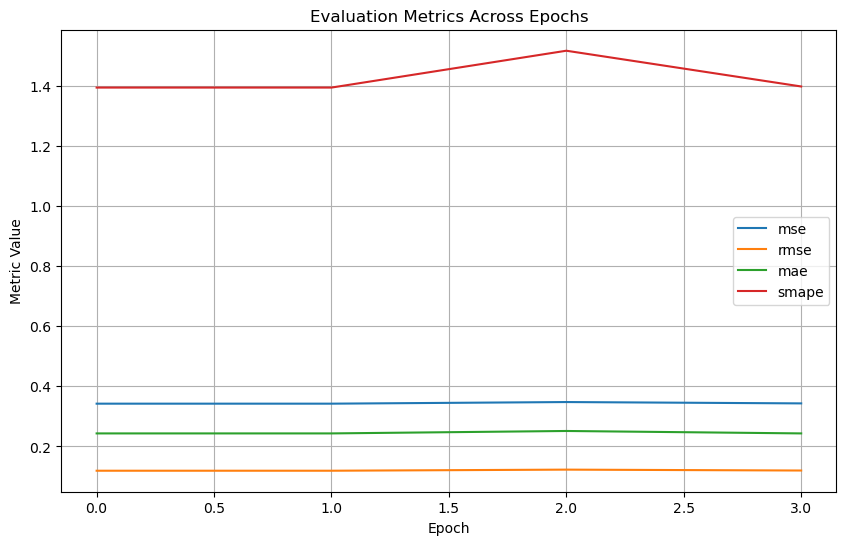

[1] [plot_eval_stats --> ]


In [33]:
# Cambiar en el momento que todo se haga con clases
enc = Encoder(mssg = Mssg(level = -1, verbose = 1))
enc.eval_stats_pre = eval_results_pre
enc.eval_stats_post = eval_results_post
enc.num_epochs = 5
print(enc.eval_stats_pre)
print(enc.eval_stats_post)
plot_eval_stats(enc)

In [34]:
embs = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)

[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([424, 1, 17])
[1] get_acts_moment | Trial 1 | About to pad X (encoder input) | exception The size of tensor a (16) must match the size of tensor b (17) at non-singleton dimension 1 | padd step: 10
[1] get_acts_moment | Trial 1 | y ~ torch.Size([424, 1, 17])
[1] ------------------- Trial 1 | Padd -----------------
[1] get_acts_moment | Trial 2 | x_enc ~ torch.Size([424, 1, 27])
[1] get_acts_moment | Trial 2 | About to pad X (encoder input) | exception The size of tensor a (24) must match the size of tensor b (27) at non-singleton dimension 1 | padd step: 10
[1] get_acts_moment | Trial 2 | y ~ torch.Size([424, 1, 27])
[1] ------------------- Trial 2  -----------------
[1] ------------------- Trial 2 | a > a_old -----------------
[1] ------------------- Trial 2 |a > a_old | Reduced |  y ~ torch.Size([424, 1, 24]) -----------------
[1]

In [35]:
embs.shape

(424, 512)

In [36]:
#enc_learner.task_name

In [37]:
timer.end()
timer.show()

19.28752589225769

In [38]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [39]:
#| hide
if reset_kernel:
    import os
    os._exit(00)